# Urine metabolome visualization

**Michiel Stock**

*Friday 21 July 2017*

Visualization of the different metabolites found in urine. Uses tSNE to make a two-dimensional projection of the fingerprint dataset. On this projection, information on the pathways, biofunction and diseases.

In [1]:
import pandas as pd
import json
import numpy as np
from sklearn.manifold import TSNE, Isomap, LocallyLinearEmbedding
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from collections import Counter
sns.set_style('white')

In [2]:
filled_markers = ('o', 'v', '^', '<', '>', '8', 's', 'p', 'h', 'H', 'D', 'd', 'P', 'X', '*')

Load the fingerprints data.

In [3]:
fingerprints = pd.DataFrame.from_csv('../Data/metabolite_fingerprints.csv')
fingerprints.head()

,0,1,2,3,4,5,6,7,8,9,...,157,158,159,160,161,162,163,164,165,166
(+)-(S)-Carvone,0,0,0,0,0,0,0,0,0,0,...,0,0,0,1,0,0,1,1,1,0
(+)-4-Carene,0,0,0,0,0,0,0,0,0,0,...,0,0,0,1,0,0,1,0,1,0
(-)-Epicatechin 3'-O-glucuronide,0,0,0,0,0,0,0,0,0,0,...,1,0,1,0,0,1,1,1,1,0
(-)-Epicatechin 7-O-glucuronide,0,0,0,0,0,0,0,0,0,0,...,1,0,1,0,0,1,1,1,1,0
(-)-Epicatechin sulfate,0,0,0,0,0,0,0,0,0,0,...,1,0,1,0,0,1,1,1,1,0


In [4]:
n_molecules, n_fingerprints = fingerprints.shape

Explore different manifold learning algorithms. TSNE seems to work best.

In [52]:
# tSNE
tsne = TSNE(perplexity=35)
X = tsne.fit_transform(fingerprints)
projection = pd.DataFrame(X, index=fingerprints.index)
projection.to_csv('../Data/tsne_projection.csv')

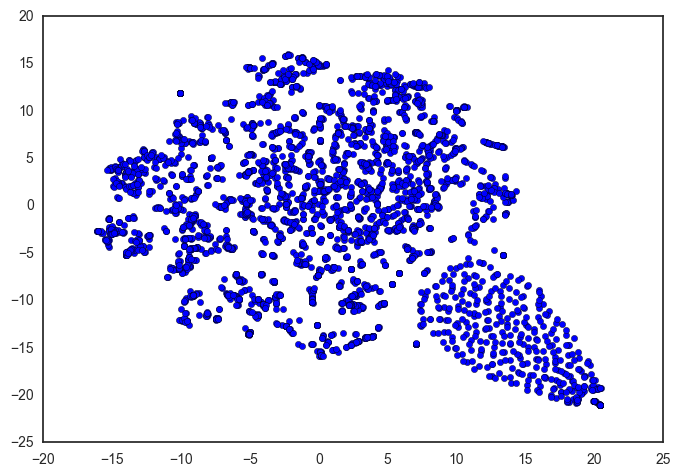

In [53]:
plt.scatter(X[:,0], X[:,1])

Load the auxilary data.

In [28]:
urine_metabolome = json.load(open('../Data/urine_metabolome.json', 'r'))

For every metabolite take the class and use the eight most common chemical classes.

In [29]:
metabolite_classes = [urine_metabolome[met]['class'] if 'class' in urine_metabolome[met] else 'Varia'
                      for met in fingerprints.index]

In [30]:
c = Counter(metabolite_classes)

In [31]:
common_classes = sorted(c.most_common(n=9))
common_classes

[('Benzene and substituted derivatives', 108),
 ('Benzenoids', 506),
 ('Lipids and lipid-like molecules', 787),
 ('Organic acids and derivatives', 389),
 ('Organic oxygen compounds', 236),
 ('Organoheterocyclic compounds', 638),
 ('Phenylpropanoids and polyketides', 276),
 ('Steroids and steroid derivatives', 89),
 ('Varia', 202)]

In [32]:
# use only common classes
metabolite_classes_subset = [cl if cl in set([cc for cc, _ in common_classes])
                             else 'Varia' for cl in metabolite_classes]

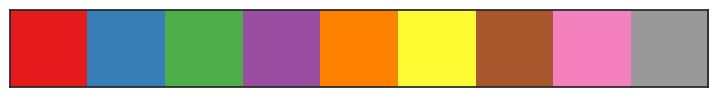

In [33]:
colors = sns.color_palette("Set1", 9)
# put gray last
#colors.append(colors.pop(-4))
sns.palplot(colors)

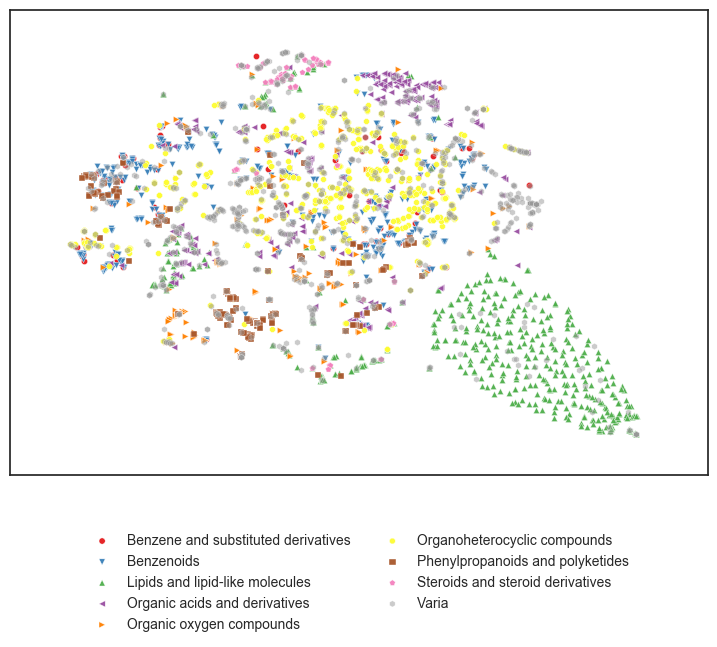

In [54]:
fig, ax = plt.subplots(figsize=(9, 6))
markers = iter(filled_markers)

for col, (cl, _) in zip(colors, common_classes):
    mask = np.array([cl_met==cl for cl_met in metabolite_classes_subset])
    ax.scatter(X[mask,0], X[mask,1], marker=next(markers), c=col, label=cl, alpha=0.95 if cl!='Varia' else 0.5, edgecolors='w')

lgd = ax.legend(loc=9, bbox_to_anchor=(0.5, -0.1), ncol=2)
ax.set_yticks([])
ax.set_xticks([])
fig.savefig('../Figures/metabolites_tsne.pdf', bbox_extra_artists=(lgd,), bbox_inches='tight')

Let us select twelve molecules (spread over the chemical space) to visualize! Use $K$-means clustering to find groups.

In [76]:
from sklearn.cluster import KMeans

n_clusters = 12

kmeans = KMeans(n_clusters=n_clusters)
cluster_ids = kmeans.fit_predict(fingerprints.values)

colors_cluster = sns.color_palette("Set1", n_clusters)

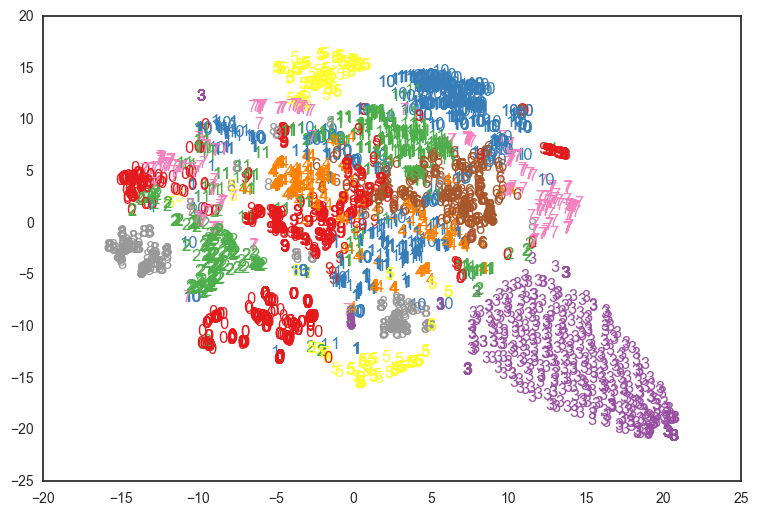

In [82]:
fig, ax = plt.subplots(figsize=(9, 6))
ax.plot(X[:,0], X[:,1], color='w')

for i, cl in enumerate(cluster_ids):
    ax.text(X[i,0], X[i,1], str(cl), color=colors_cluster[cl])
    
fig.savefig('../Figures/metabolites_clustering.pdf') 

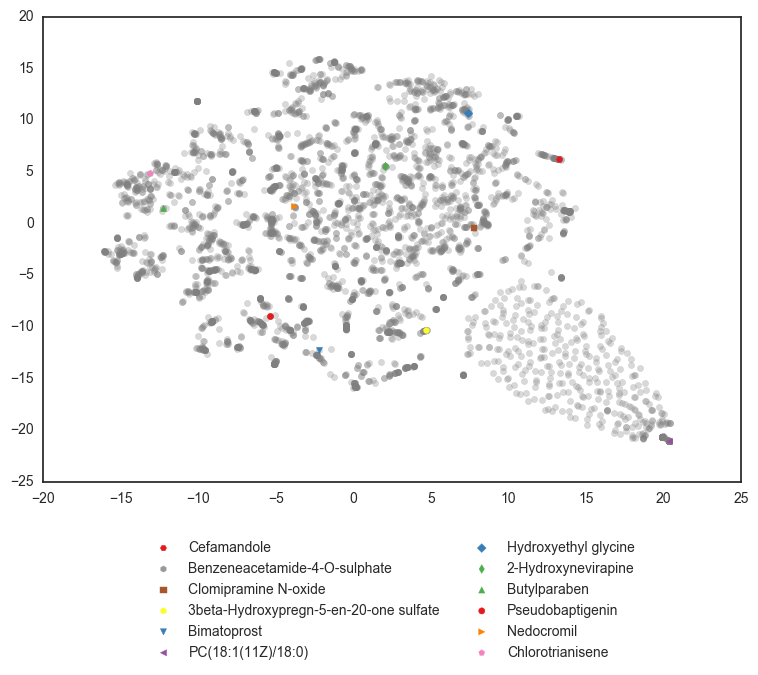

In [83]:
from random import randint

fig, ax = plt.subplots(figsize=(9, 6))
ax.scatter(X[:,0], X[:,1], color='gray', alpha=0.3)

clusters_to_pick = set(cluster_ids)

while len(clusters_to_pick):
    i = randint(0, n_molecules-1)
    cl_ind = cluster_ids[i]
    if cl_ind in clusters_to_pick and len(fingerprints.index[i]) < 80:
        clusters_to_pick.remove(cl_ind)
        ax.scatter(X[i,0], X[i,1], marker=filled_markers[cl_ind], color=colors_cluster[cl_ind], label=fingerprints.index[i])
        
lgd = ax.legend(loc=9, bbox_to_anchor=(0.5, -0.1), ncol=2)
fig.savefig('../Figures/metabolites_cluster_examples.pdf', bbox_extra_artists=(lgd,), bbox_inches='tight')  

Now, we superpose some information on the different biofunctions, diseases and pathways the metabolites are involved with.

In [58]:
diseases = []
biofunctions = []
pathways = []

for metabolite in urine_metabolome.values():
    if 'diseases' in metabolite:
        diseases += metabolite['diseases']
    if 'biofunctions' in metabolite:
        biofunctions += metabolite['biofunctions']
    if 'pathways' in metabolite:
        pathways += metabolite['pathways']

In [59]:
diseases_counter = Counter(diseases)
diseases_counter.most_common(n=9)

[('Schizophrenia', 97),
 ("Alzheimer's disease", 71),
 ('Lung Cancer', 33),
 ("Parkinson's disease", 32),
 ('Multiple sclerosis', 28),
 ('Kidney disease', 24),
 ('Epilepsy', 22),
 ('Leukemia', 22),
 ('Diabetes mellitus type 2', 21)]

In [60]:
biofunctions_counter = Counter(biofunctions)
biofunctions_counter.most_common(n=9)

[('Waste products', 1182),
 ('Membrane integrity/stability', 950),
 ('Fuel or energy source', 950),
 ('Fuel and energy storage', 950),
 ('Cell signaling', 949),
 ('Energy source', 508),
 ('Membrane component', 506),
 ('Nutrient', 276),
 ('Anti-Bacterial Agents', 117)]

In [61]:
pathways_counter = Counter(pathways)
pathways_counter.most_common(n=9)

[('Dimethylglycine Dehydrogenase Deficiency', 74),
 ('Disulfiram Pathway', 45),
 ('Azathioprine Pathway', 42),
 ('Methylenetetrahydrofolate Reductase Deficiency (MTHFRD)', 42),
 ('Thioguanine Pathway', 41),
 ('Tyrosine Metabolism', 41),
 ('Mercaptopurine Pathway', 40),
 ('Glycine and Serine Metabolism', 39),
 ('Alkaptonuria', 38)]

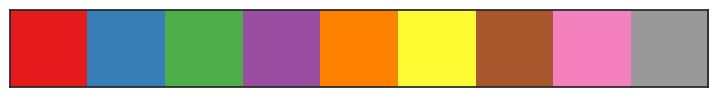

In [93]:
colors = sns.color_palette("Set1", 9)
sns.palplot(colors)

figsize = (9, 9)
fontsize = 14

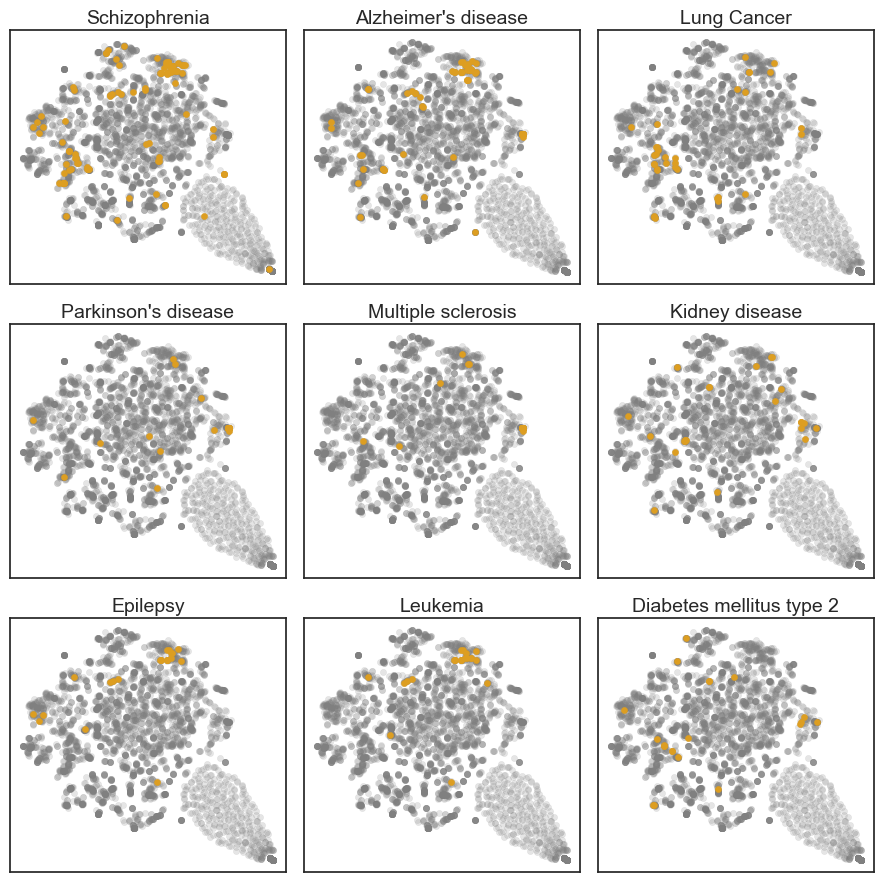

In [94]:
fig, axes = plt.subplots(nrows=3, ncols=3, figsize=figsize)

axes = iter([ax for axr in axes for ax in axr])
colors_iter = iter(colors)

for dis, _ in diseases_counter.most_common(n=9):
    ax = next(axes)
    col = next(colors_iter)
    ax.set_title(dis, fontsize=fontsize)
    ax.scatter(X[:,0], X[:,1], alpha=0.2, color='gray')
    for i, (x0, x1) in enumerate(X):
        met_name = fingerprints.index[i]
        if 'diseases' in urine_metabolome[met_name] and dis in urine_metabolome[met_name]['diseases']:
            ax.scatter(x0, x1, color='#DD9E21')
        ax.set_xticks([])
        ax.set_yticks([])

fig.tight_layout()
fig.savefig('../Figures/diseases.pdf')

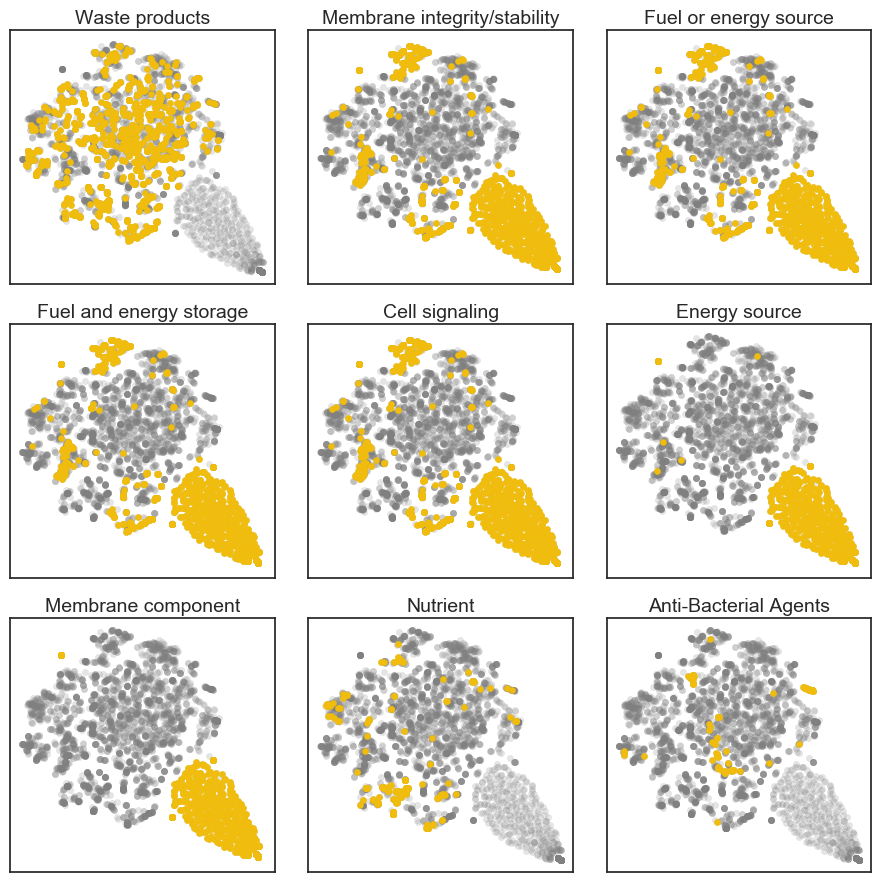

In [95]:
fig, axes = plt.subplots(nrows=3, ncols=3, figsize=figsize)

axes = iter([ax for axr in axes for ax in axr])
colors_iter = iter(colors)

for biofun, _ in biofunctions_counter.most_common(n=9):
    ax = next(axes)
    col = next(colors_iter)
    ax.set_title(biofun, fontsize=fontsize)
    ax.scatter(X[:,0], X[:,1], alpha=0.2, color='gray')
    for i, (x0, x1) in enumerate(X):
        met_name = fingerprints.index[i]
        if 'biofunctions' in urine_metabolome[met_name] and biofun in urine_metabolome[met_name]['biofunctions']:
            ax.scatter(x0, x1, color='#F0BD0E')
        ax.set_xticks([])
        ax.set_yticks([])
        
fig.tight_layout()   
fig.savefig('../Figures/biofunction.pdf')

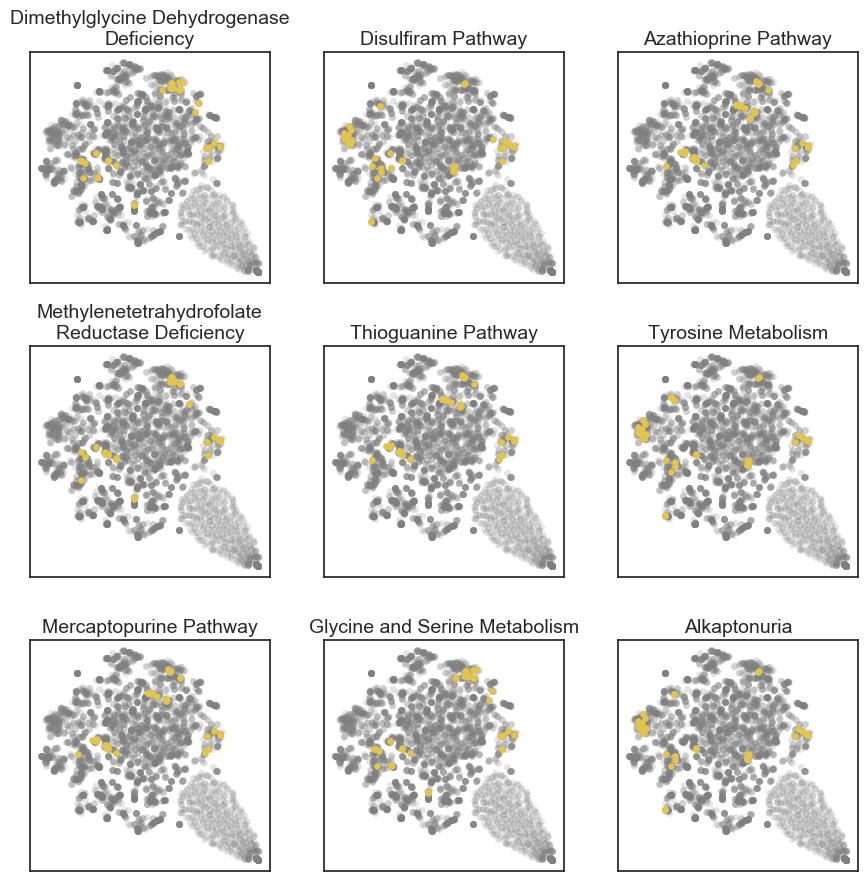

In [96]:
fig, axes = plt.subplots(nrows=3, ncols=3, figsize=figsize)

axes = iter([ax for axr in axes for ax in axr])
colors_iter = iter(colors)

for pathw, _ in pathways_counter.most_common(n=9):
    ax = next(axes)
    col = next(colors_iter)
    if 'Reductase' in pathw:
        ax.set_title('Methylenetetrahydrofolate\nReductase Deficiency', fontsize=fontsize)
    elif 'Dimethylglycine Dehydrogenase Deficiency' in pathw:
        ax.set_title('Dimethylglycine Dehydrogenase\nDeficiency', fontsize=fontsize)
    else:
        ax.set_title(pathw, fontsize=fontsize)
    ax.scatter(X[:,0], X[:,1], alpha=0.2, color='gray')
    for i, (x0, x1) in enumerate(X):
        met_name = fingerprints.index[i]
        if 'pathways' in urine_metabolome[met_name] and pathw in urine_metabolome[met_name]['pathways']:
            ax.scatter(x0, x1, color='#E2C551')
        ax.set_xticks([])
        ax.set_yticks([])
      
fig.tight_layout()
fig.savefig('../Figures/pathways.pdf')

Take a look at some molecular descriptors (less interesting here though...)

In [66]:
descriptors = pd.DataFrame.from_csv('../Data/metabolite_descriptors.csv')
descriptors['class'] = [urine_metabolome[met]['class'] if 'class' in urine_metabolome[met] and 
                        urine_metabolome[met]['class'] in set([cc for cc, _ in common_classes]) else 'Varia'
                        for met in descriptors.index]
# remove very large molecule
descriptors = descriptors.loc[descriptors['Ring count'] < 20]
descriptors.head()

,Mol. Wt,NHOH count,Num. H acceptors,Num. H donors,Ring count,logP,class
"N,O-Didesmethylvenlafaxine",249.354,3,3,3,2,2.3904,Organic oxygen compounds
Ursocholic acid,408.579,4,4,4,4,3.4487,Varia
"5-Hydroxy, 6-methoxy duloxetine sulfate",407.444,2,7,2,3,3.3526,Benzenoids
Griseofulvin,352.770,0,6,0,3,2.8103,Varia
4-Methoxyphenylacetic acid,166.176,1,2,1,1,1.3223,Benzenoids


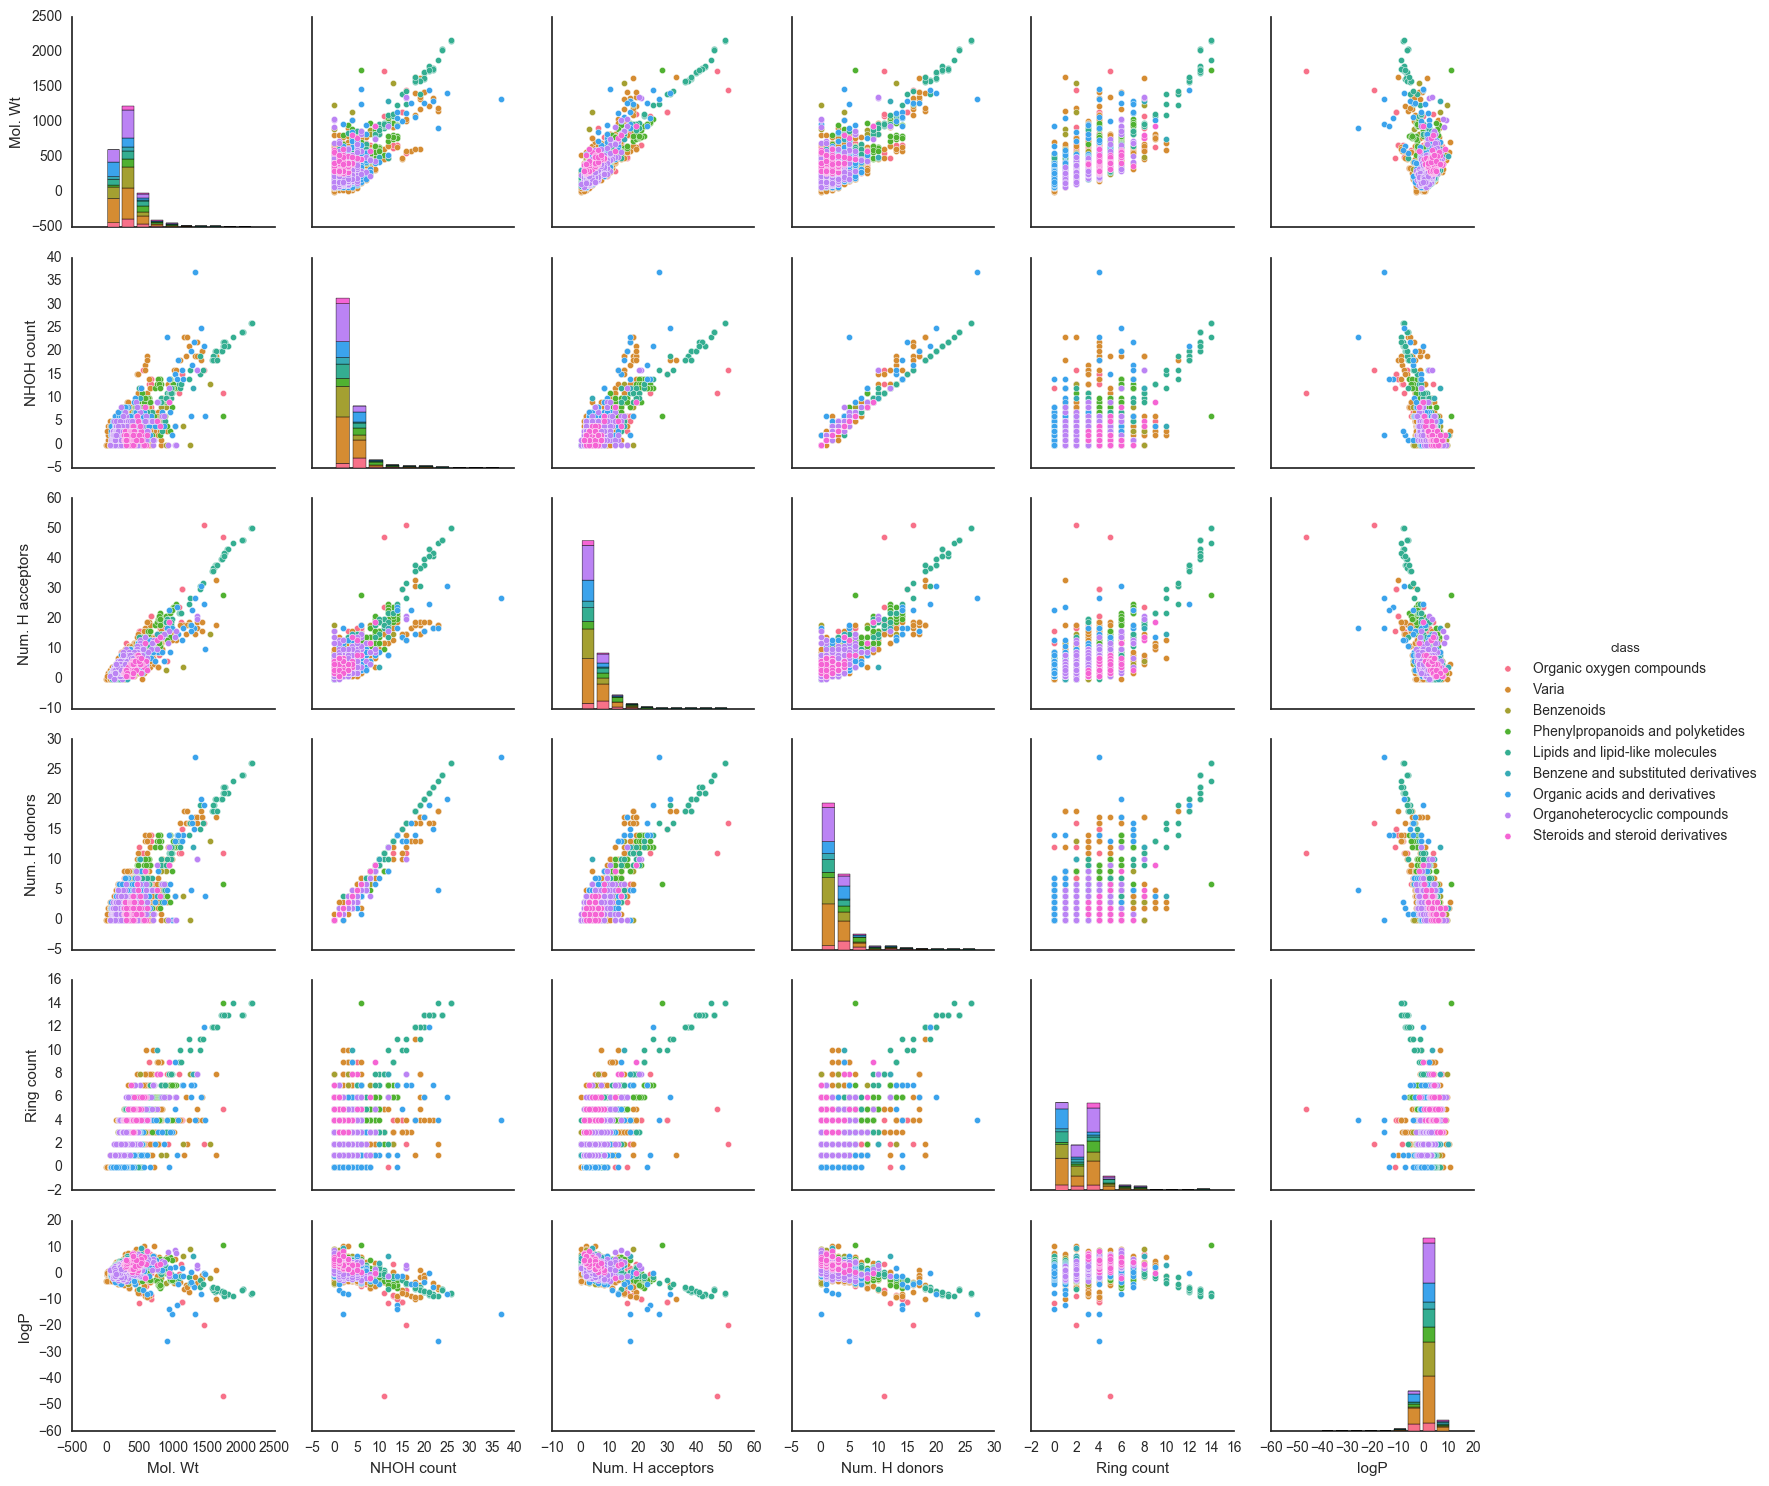

In [67]:
fig = sns.pairplot(descriptors, hue='class')
fig.savefig('../Figures/descriptors_pairplot.pdf')